In [1]:
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
import keras 
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam, AdamW, RMSprop
from tensorflow.keras import initializers

from keras.datasets import fashion_mnist

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint 
from keras.metrics import categorical_accuracy

from sklearn.metrics import confusion_matrix

За порадою лектора зробимо ініціалізацію random не зовсім рандомною

In [2]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    

set_seed(42)

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

__Подивимось на наші вихідні данні.__

x_train.shape: (60000, 28, 28), y_train.shape: (60000,)
x_test.shape: (10000, 28, 28), y_test.shape: (10000,)
x_train.min() = 0, x_train.max() = 255
x_test.min() = 0, x_test.max() = 255
y_train.min() = 0, y_train.max() = 9
y_test.min() = 0, y_test.max() = 9


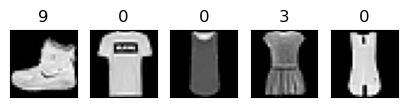

In [4]:
print(f"x_train.shape: {x_train.shape}, y_train.shape: {y_train.shape}")
print(f"x_test.shape: {x_test.shape}, y_test.shape: {y_test.shape}")
print(f"x_train.min() = {x_train.min()}, x_train.max() = {x_train.max()}")
print(f"x_test.min() = {x_test.min()}, x_test.max() = {x_test.max()}")
print(f"y_train.min() = {y_train.min()}, y_train.max() = {y_train.max()}")
print(f"y_test.min() = {y_test.min()}, y_test.max() = {y_test.max()}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(5, 1))
for i in range(5):
    axs[i].imshow(x_train[i], cmap="gray")  
    axs[i].set_title(f"{y_train[i]}")
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)    
plt.show()

Подивимось на розподіл наших данних в трейні та тесті.


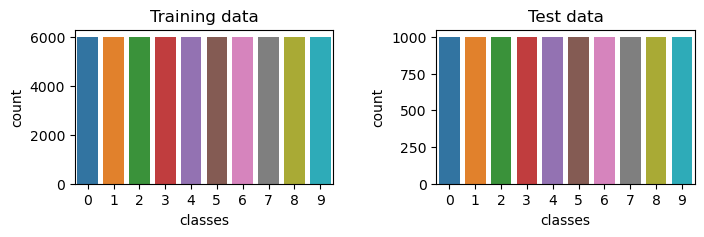

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 2),
                               gridspec_kw={"wspace": 0.4, "hspace": 0.4})
sns.countplot(x=y_train, ax=ax1)
sns.countplot(x=y_test, ax=ax2)

ax1.set_title("Training data")
ax1.set_xlabel("classes")
ax2.set_title("Test data")
ax2.set_xlabel("classes")


plt.show()

In [6]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# Нормалізуемо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Категорізуємо наші класи
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

### __Створимо "найнаївнішу" (сподобалось визначення від GoIT) модель та натренуємо її (але одразу візьмемо модні функцію активації relu та оптимізатор adam)__

In [8]:
class NLayer:
    def __init__(self, n_neurons: int=128, dropout_rate: float=None, activation="relu"):
        self.n_neurons = n_neurons
        self.dropout_rate = dropout_rate
        self.activation = activation 

    
class HyperParameters:
    def __init__(self, layers: list[NLayer]=None, optimizer=None):
        self.layers = layers if layers else [NLayer()]
        self.optimizer = optimizer if optimizer else Adam(learning_rate=0.001)

        
def create_model(hp: HyperParameters) -> Sequential:
    model= keras.Sequential()
    model.add(Flatten(input_shape=(28,28)))
    
    for i in range(len(hp.layers)):
        model.add(Dense(hp.layers[i].n_neurons, activation=hp.layers[i].activation))
        if(hp.layers[i].dropout_rate):
            model.add(Dropout(hp.layers[i].dropout_rate))
    
    model.add(Dense(10, activation="softmax"))
    
    model.compile(optimizer=hp.optimizer, loss="categorical_crossentropy", metrics=["categorical_accuracy"])

    return model


def evaluate_model(model: Sequential, history: dict):
    score_train = model.evaluate(x_train, y_train_cat, verbose=0)
    score_test = model.evaluate(x_test, y_test_cat, verbose=0)
    print(f"Train loss: {score_train[0]}, train accuracy: {score_train[1]}")
    print(f"Test loss:  {score_test[0]}, test accuracy:  {score_test[1]}")

    print("\nTrain")
    print(f"Min loss : {np.array(history['loss']).min()}, "
          f"epoch num: {np.argmin(history['loss']) + 1}")
    print(f"Max accuracy : {np.array(history['categorical_accuracy']).max()}, "
          f"epoch num: {np.argmax(history['categorical_accuracy']) + 1}")
    print("\nValidation")
    print(f"Min loss : {np.array(history['val_loss']).min()}, "
          f"epoch num: {np.argmin(history['val_loss']) + 1}")
    print(f"Max accuracy : {np.array(history['val_categorical_accuracy']).max()}, "
          f"epoch num: {np.argmax(history['val_categorical_accuracy']) + 1}")    
    

def loss_accuracy_plotting(history: dict, title: str=None, title_y=1.1):
    num_epochs = len(history[list(history.keys())[0]])

    x = np.arange(1, num_epochs + 1)
    x_xticks = np.arange(0, num_epochs+1, num_epochs/10)    
        
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4),
                                   gridspec_kw={"wspace": 0.2})
    
    ax1.plot(x, history["loss"])
    ax1.plot(x, history["val_loss"])
    ax1.set_title("loss and val_loss")

    ax2.plot(x, history["categorical_accuracy"])
    ax2.plot(x ,history["val_categorical_accuracy"])
    ax2.set_title("accuracy and val_accuracy")

    ax1.grid(True)
    ax1.set_xticks(x_xticks)
    ax1.set_xlabel("epochs")

    ax2.grid(True)
    ax2.set_xticks(x_xticks)
    ax2.set_xlabel("epochs")
    
    if title:
        fig.suptitle(title, y=title_y)
    plt.show()

    
def multi_val_loss_accuracy_plotting(val_loss: dict, val_accuracy: dict, title: str=None, title_y=1):
    num_epochs = len(val_loss[list(val_loss.keys())[0]])

    x = np.arange(1, num_epochs + 1)
    x_xticks = np.arange(0, num_epochs+1, num_epochs/10)    
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6),
                                   gridspec_kw={"wspace": 0.2, "hspace": 0.4})
    
    for i in range(len(val_loss)):
        ax1.plot(x, val_loss[list(val_loss.keys())[i]])
        ax2.plot(x, val_accuracy[list(val_accuracy.keys())[i]])
    
    ax1.set_title("val_loss")
    ax1.set_xticks(x_xticks)
    ax1.set_xlabel("epochs")
    ax1.grid(True)
    ax2.set_title("val_accuracy")
    ax2.set_xticks(x_xticks)
    ax2.set_xlabel("epochs")
    ax2.grid(True)
    
    ax1.legend(val_loss.keys())    
    ax2.legend(val_accuracy.keys())  
    
    if title:
        fig.suptitle(title, y=title_y)
    plt.show()           

__Перший тик в небо.__

Train loss: 0.21321502327919006, train accuracy: 0.9245499968528748
Test loss:  0.3489208519458771, test accuracy:  0.8838000297546387

Train
Min loss : 0.19657091796398163, epoch num: 30
Max accuracy : 0.9295833110809326, epoch num: 30

Validation
Min loss : 0.31341108679771423, epoch num: 21
Max accuracy : 0.8915833234786987, epoch num: 29


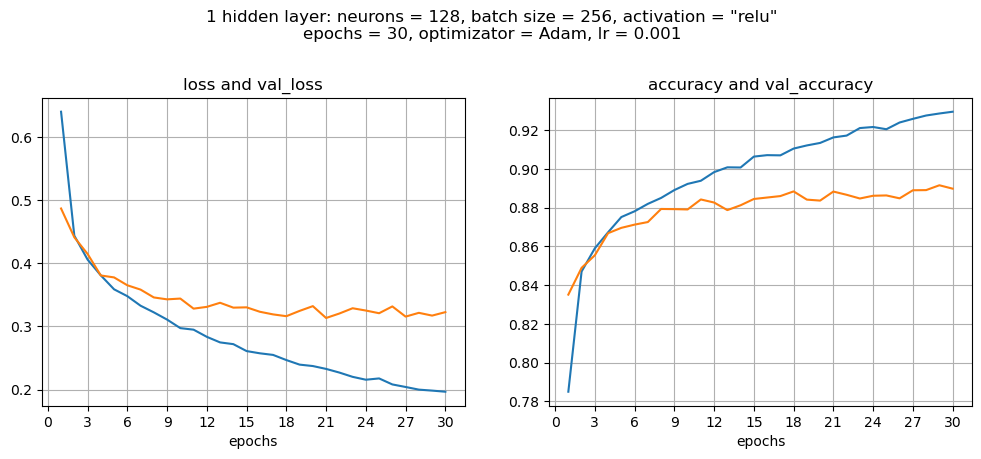

In [11]:
layers = [NLayer(n_neurons=128)]
N_EPOCHS = 30
BATCH_SIZE = 256

model = create_model(HyperParameters(layers=layers))
history = model.fit(x_train, y_train_cat, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_split=0.20, verbose=0)
evaluate_model(model, history.history)

title = "1 hidden layer: neurons = 128, batch size = 256, activation = \"relu\"\nepochs = 30, optimizator = Adam, lr = 0.001"
loss_accuracy_plotting(history.history, title=title)

Починаючи приблизно з 20 епохи val_loss виходить на плато. Можливо варто зменшити LR.

### 1. Залежність val_accuracy та val_loss від кількості нейронів в шарі.

In [14]:
n_neurons = [256, 512, 768]
val_accurasy = {}
val_loss = {}

for n_n in n_neurons:
    model = create_model(HyperParameters(layers=[NLayer(n_n)]))
    history = model.fit(x_train, y_train_cat, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_split=0.20, verbose=0)
    val_accurasy[n_n] = history.history["val_categorical_accuracy"]  
    val_loss[n_n] = history.history["val_loss"]

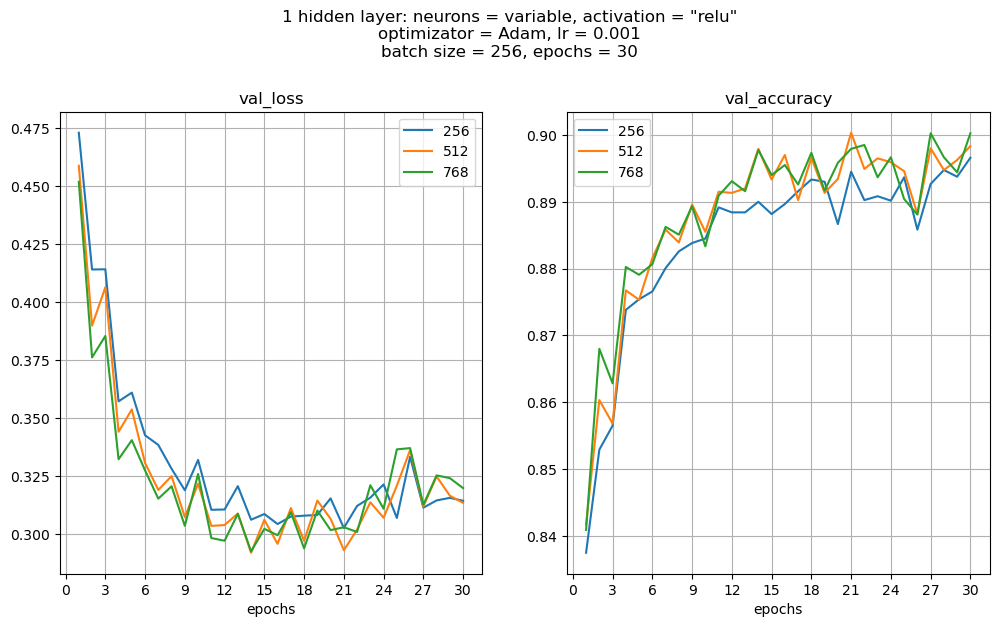

In [15]:
title = f"1 hidden layer: neurons = variable, activation = \"relu\""\
f"\noptimizator = Adam, lr = 0.001\nbatch size = {BATCH_SIZE}, epochs = {N_EPOCHS}"
multi_val_loss_accuracy_plotting(val_loss, val_accurasy, title=title, title_y=1.05)

За великим рахунком відчутної різниці 512 чи 768, як показала практика, немає, але візьмемо 768.

###  2. Залежність val_accuracy та val_loss від розміру батча.

In [16]:
batch_sizes = list(np.arange(128, 768, 128))
layers = [NLayer(n_neurons=768)]
val_accurasy = {}
val_loss = {}

for b_s in batch_sizes:
    model = create_model(HyperParameters(layers=layers))
    history = model.fit(x_train, y_train_cat, batch_size=b_s, epochs=N_EPOCHS, validation_split=0.20, verbose=0)
    val_accurasy[b_s] = history.history["val_categorical_accuracy"]  
    val_loss[b_s] = history.history["val_loss"]

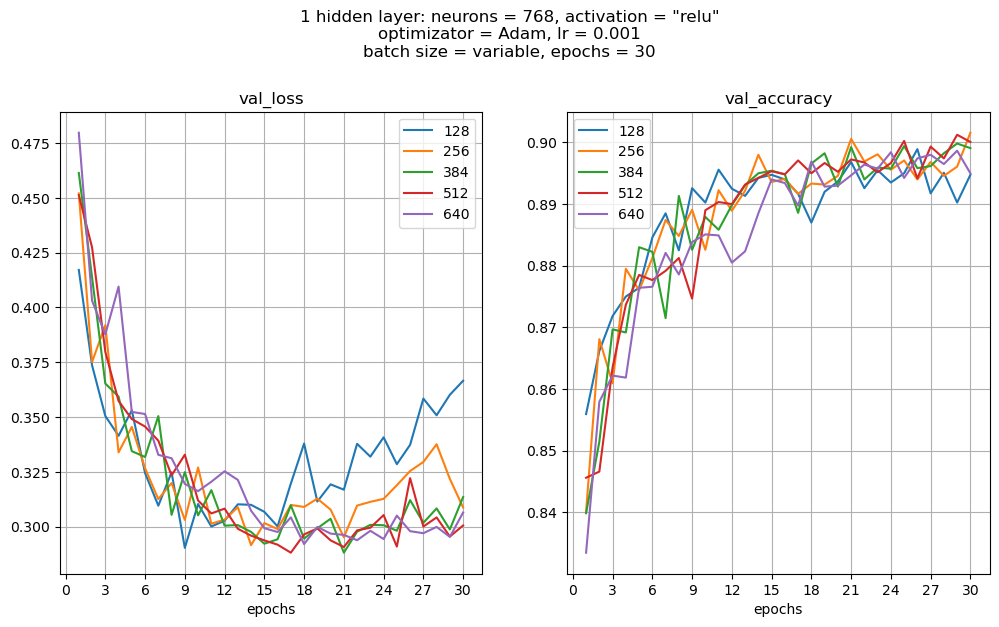

In [17]:
title = f"1 hidden layer: neurons = 768, activation = \"relu\""\
f"\noptimizator = Adam, lr = 0.001\nbatch size = variable, epochs = {N_EPOCHS}"
multi_val_loss_accuracy_plotting(val_loss, val_accurasy, title=title, title_y=1.05)

Графік показує, що чим менший розмір батчу - тим швидше модель починає перенавчатися. 384 чи 512? Хай буде 384.

### 3. Контрольна точка з кількістю нейронів 768 та розміром батча 384

Train loss: 0.14741875231266022, train accuracy: 0.95169997215271
Test loss:  0.331683874130249, test accuracy:  0.896399974822998

Train
Min loss : 0.12313929945230484, epoch num: 30
Max accuracy : 0.9574375152587891, epoch num: 30

Validation
Min loss : 0.28420352935791016, epoch num: 16
Max accuracy : 0.9026666879653931, epoch num: 21


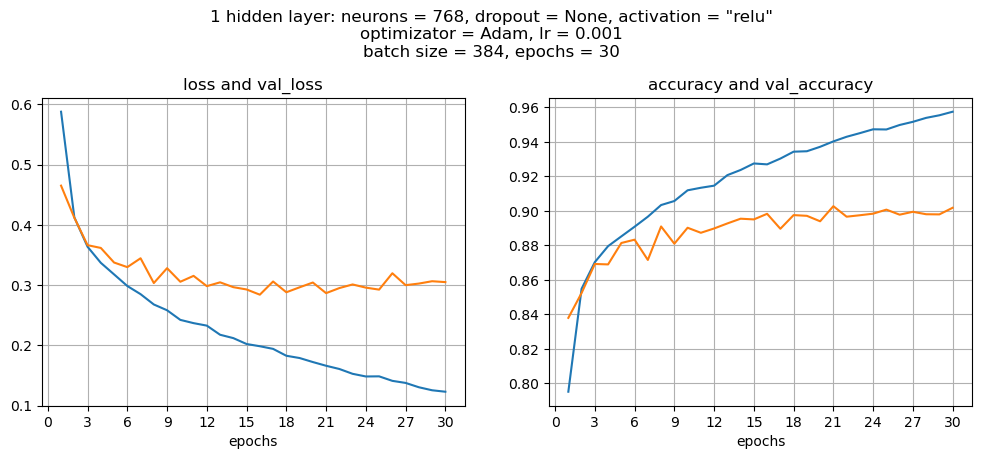

In [18]:
BATCH_SIZE = 384

layers = [NLayer(768)]

model = create_model(HyperParameters(layers=layers))
history = model.fit(x_train, y_train_cat, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_split=0.20, verbose=0)
evaluate_model(model, history.history)

title = f"1 hidden layer: neurons = 768, dropout = None, activation = \"relu\""\
f"\noptimizator = Adam, lr = 0.001\nbatch size = {BATCH_SIZE}, epochs = {N_EPOCHS}"
loss_accuracy_plotting(history.history, title=title)

Після 18 епохи перенавчання. Зменшимо LR - наприклад 0.001 * 18 / 30 = 0,0006

Train loss: 0.1658373475074768, train accuracy: 0.9438166618347168
Test loss:  0.32129010558128357, test accuracy:  0.8939999938011169

Train
Min loss : 0.14464055001735687, epoch num: 30
Max accuracy : 0.9496666789054871, epoch num: 30

Validation
Min loss : 0.2863476872444153, epoch num: 25
Max accuracy : 0.9018333554267883, epoch num: 28


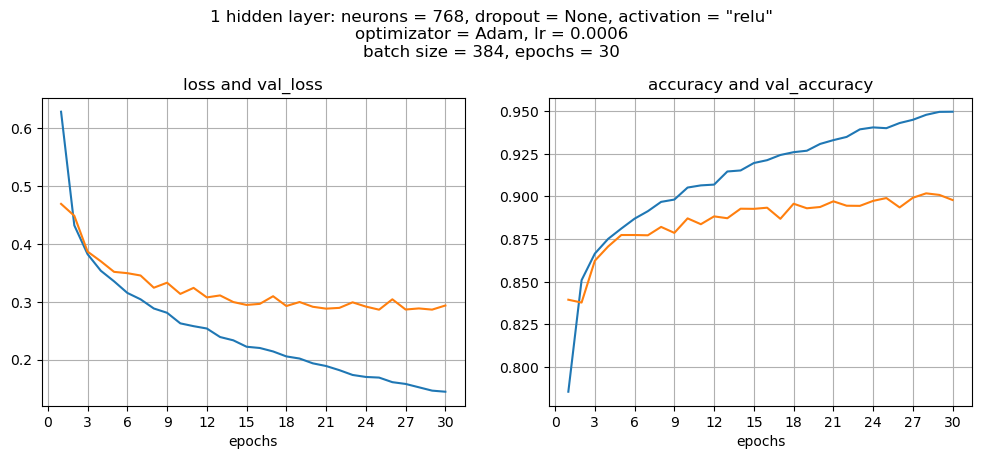

In [19]:
BATCH_SIZE = 384

layers = [NLayer(768)]
optimizer = Adam(learning_rate=0.0006)

model = create_model(HyperParameters(layers=layers, optimizer=optimizer))
history = model.fit(x_train, y_train_cat, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_split=0.20, verbose=0)
evaluate_model(model, history.history)

title = f"1 hidden layer: neurons = 768, dropout = None, activation = \"relu\""\
f"\noptimizator = Adam, lr = 0.0006\nbatch size = {BATCH_SIZE}, epochs = {N_EPOCHS}"
loss_accuracy_plotting(history.history, title=title)

Точка перенавчання змістилася вправо - залишаємо LR = 0.0006

### 4. Поборемося з перенавчанням за допомогою технології dropout

In [20]:
dropout_rates = [0.3, 0.5, 0.6]
val_accurasy = {}
val_loss = {}

for d_r in dropout_rates:
    optimizer = Adam(learning_rate=0.0006)
    model = create_model(HyperParameters(layers=[NLayer(768, d_r)], optimizer=optimizer))
    history = model.fit(x_train, y_train_cat, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_split=0.20, verbose=0)
    val_accurasy[d_r] = history.history["val_categorical_accuracy"]  
    val_loss[d_r] = history.history["val_loss"] 

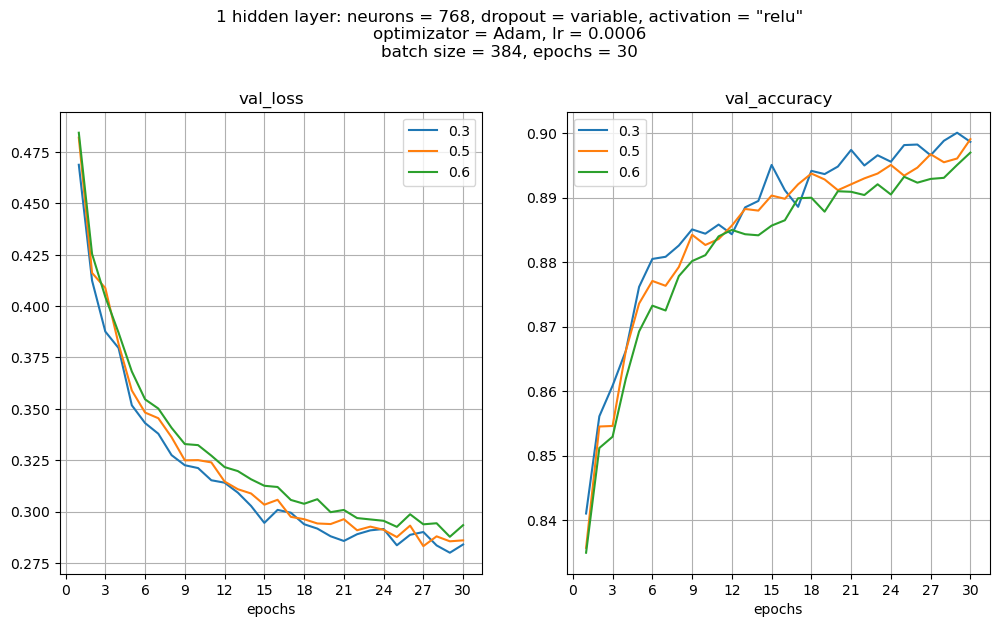

In [21]:
title = f"1 hidden layer: neurons = 768, dropout = variable, activation = \"relu\""\
f"\noptimizator = Adam, lr = 0.0006\nbatch size = {BATCH_SIZE}, epochs = {N_EPOCHS}"
multi_val_loss_accuracy_plotting(val_loss, val_accurasy, title=title, title_y=1.05)

### 5. Контрольна точка з кількістю нейронів 768, dropout = 0.3 та розміром батча 384

Train loss: 0.18284691870212555, train accuracy: 0.9360499978065491
Test loss:  0.3101899325847626, test accuracy:  0.8938999772071838

Train
Min loss : 0.18727171421051025, epoch num: 30
Max accuracy : 0.9315416812896729, epoch num: 29

Validation
Min loss : 0.27958130836486816, epoch num: 29
Max accuracy : 0.9002500176429749, epoch num: 30


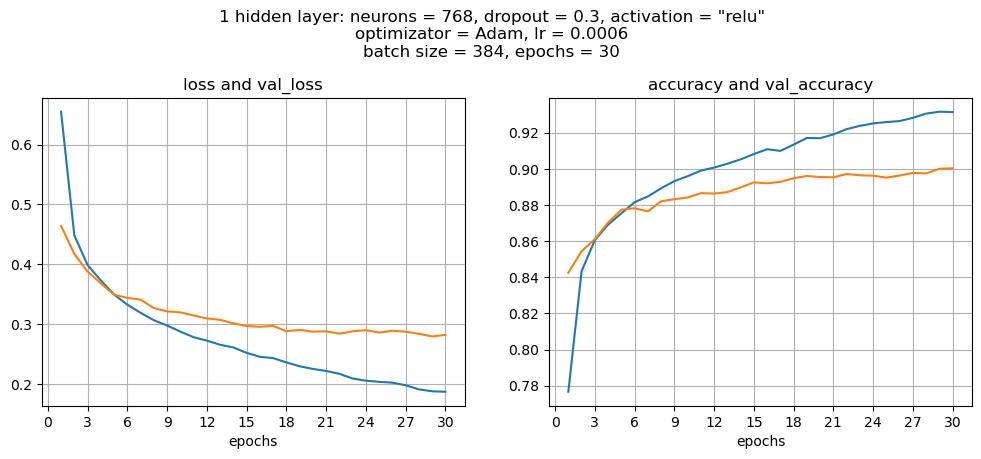

In [22]:
layers = [NLayer(768, 0.3)]
optimizer = Adam(learning_rate=0.0006)

model = create_model(HyperParameters(layers=layers, optimizer=optimizer))
history = model.fit(x_train, y_train_cat, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_split=0.20, verbose=0)
evaluate_model(model, history.history)

title = f"1 hidden layer: neurons = 768, dropout = 0.3, activation = \"relu\""\
f"\noptimizator = Adam, lr = 0.0006\nbatch size = {BATCH_SIZE}, epochs = {N_EPOCHS}"
loss_accuracy_plotting(history.history, title=title)

Графіки виглядають краще за самий перший варіант. Можливо прийшов час добавити в модель новий прихований шар.

### 6. Модель з двома прихованими шарами.

In [23]:
n_neurons = [128, 256, 512]
val_accurasy = {}
val_loss = {}

for n_n in n_neurons:
    layers = [NLayer(768, 0.3), NLayer(n_n)]
    optimizer = Adam(learning_rate=0.0006)
    
    model = create_model(HyperParameters(layers=layers, optimizer=optimizer))
    history = model.fit(x_train, y_train_cat, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_split=0.20, verbose=0)
    val_accurasy[n_n] = history.history["val_categorical_accuracy"]  
    val_loss[n_n] = history.history["val_loss"]

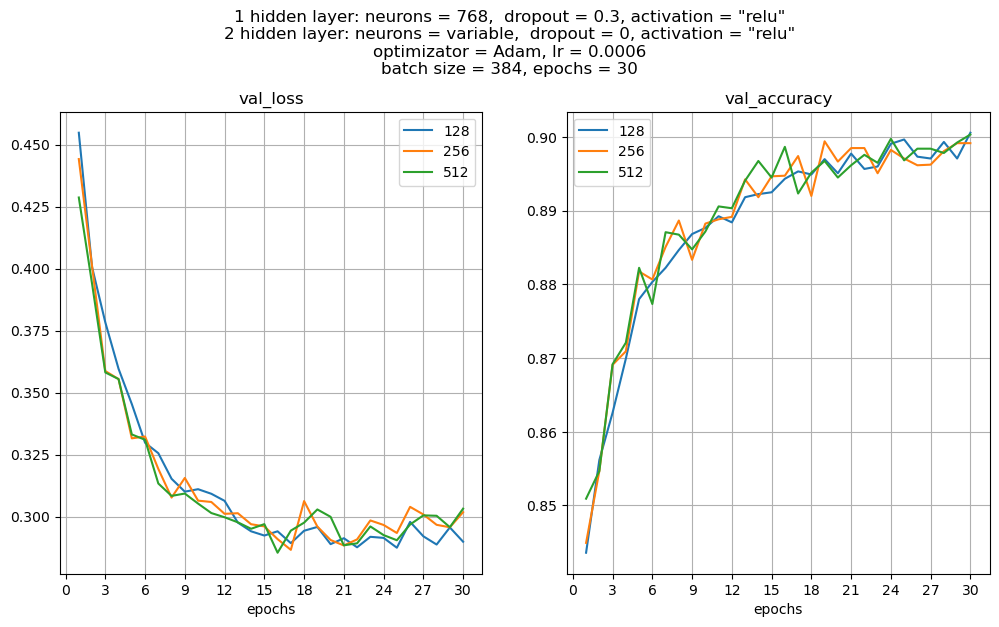

In [24]:
title = f"1 hidden layer: neurons = 768,  dropout = 0.3, activation = \"relu\""\
f"\n2 hidden layer: neurons = variable,  dropout = 0, activation = \"relu\""\
f"\noptimizator = Adam, lr = 0.0006\nbatch size = {BATCH_SIZE}, epochs = {N_EPOCHS}"

multi_val_loss_accuracy_plotting(val_loss, val_accurasy, title=title, title_y=1.05)

Хай кількість нейронів в другому шарі буде 256. Добавимо dropout в другий шар. Ну і збільшимо dropout в першому шарі до 0.5 із-за ускладнення моделі.

In [25]:
dropout_rates = [0.3, 0.5, 0.6]
val_accurasy = {}
val_loss = {}

for d_r in dropout_rates:
    layers = [NLayer(768, 0.5), NLayer(256, d_r)]
    optimizer = Adam(learning_rate=0.0006)
    
    model = create_model(HyperParameters(layers=layers, optimizer=optimizer))
    history = model.fit(x_train, y_train_cat, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_split=0.20, verbose=0)
    val_accurasy[d_r] = history.history["val_categorical_accuracy"]  
    val_loss[d_r] = history.history["val_loss"]

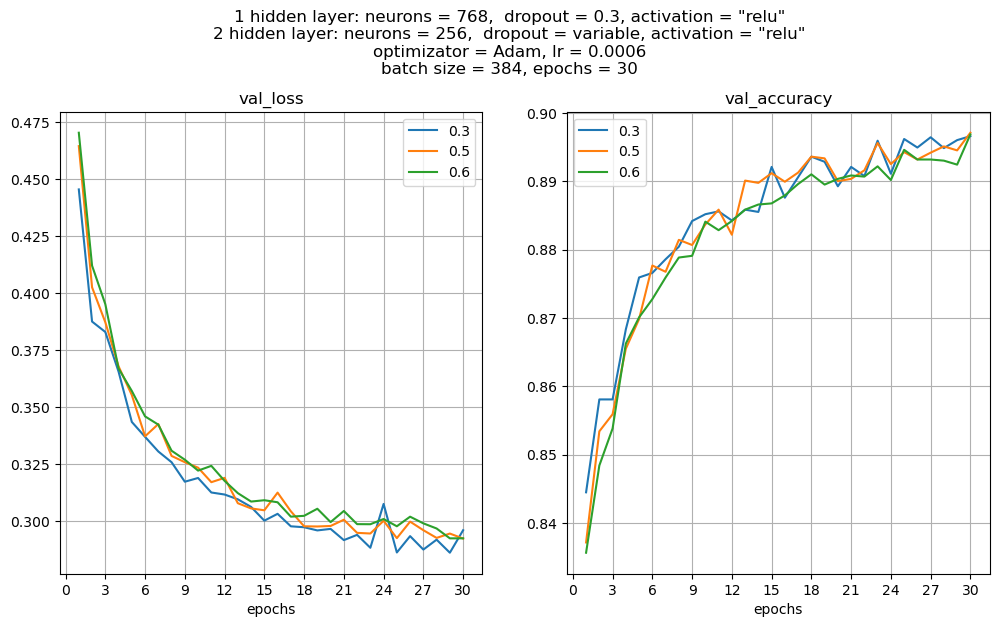

In [26]:
title = f"1 hidden layer: neurons = 768,  dropout = 0.3, activation = \"relu\""\
f"\n2 hidden layer: neurons = 256,  dropout = variable, activation = \"relu\""\
f"\noptimizator = Adam, lr = 0.0006\nbatch size = {BATCH_SIZE}, epochs = {N_EPOCHS}"

multi_val_loss_accuracy_plotting(val_loss, val_accurasy, title=title, title_y=1.05)

Виберемо dropout другого шару 0.3

### 7. Контрольна точка з двома шарами (768, 0.5) та (256, 0.3) 

Train loss: 0.20415259897708893, train accuracy: 0.9254500269889832
Test loss:  0.3181315064430237, test accuracy:  0.892799973487854

Train
Min loss : 0.2345353364944458, epoch num: 29
Max accuracy : 0.9127500057220459, epoch num: 29

Validation
Min loss : 0.2886909246444702, epoch num: 27
Max accuracy : 0.8986666798591614, epoch num: 30


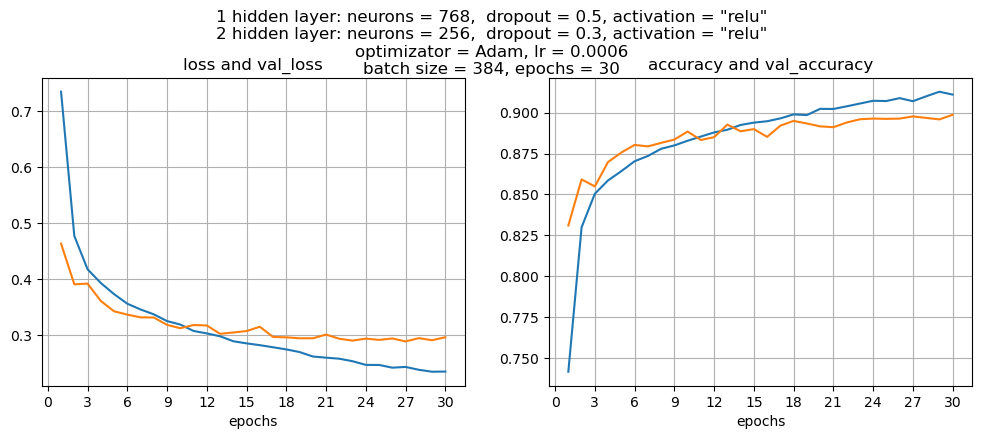

In [27]:
layers = [NLayer(768, 0.5), NLayer(256, 0.3)]
optimizer = Adam(learning_rate=0.0006)

model = create_model(HyperParameters(layers=layers, optimizer=optimizer))
history = model.fit(x_train, y_train_cat, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_split=0.20, verbose=0)
evaluate_model(model, history.history)

title = f"1 hidden layer: neurons = 768,  dropout = 0.5, activation = \"relu\""\
f"\n2 hidden layer: neurons = 256,  dropout = 0.3, activation = \"relu\""\
f"\noptimizator = Adam, lr = 0.0006\nbatch size = {BATCH_SIZE}, epochs = {N_EPOCHS}"
loss_accuracy_plotting(history.history, title=title, title_y=1.05)

Дельта між val_acc та test_acc приблизно 0.6 % і це один з найкращих результатів який я зміг досягнути.

__Але такі самі результати, а може й кращі, можна досягти і з одним шаром, збільшивши dropout до 0.6 та кількість епох до 40.__ 

Train loss: 0.2015356868505478, train accuracy: 0.9278500080108643
Test loss:  0.3103293478488922, test accuracy:  0.8956000208854675

Train
Min loss : 0.224615216255188, epoch num: 39
Max accuracy : 0.917312502861023, epoch num: 40

Validation
Min loss : 0.2825046479701996, epoch num: 37
Max accuracy : 0.8990833163261414, epoch num: 40


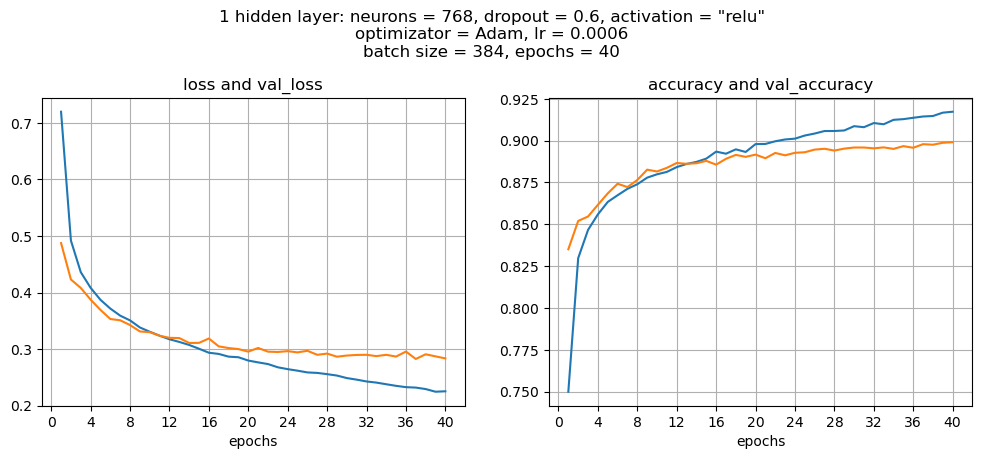

In [28]:
layers = [NLayer(768, 0.6)]
optimizer = Adam(learning_rate=0.0006)

model = create_model(HyperParameters(layers=layers, optimizer=optimizer))
history = model.fit(x_train, y_train_cat, batch_size=BATCH_SIZE, epochs=40, validation_split=0.20, verbose=0)
evaluate_model(model, history.history)

title = f"1 hidden layer: neurons = 768, dropout = 0.6, activation = \"relu\""\
f"\noptimizator = Adam, lr = 0.0006\nbatch size = {BATCH_SIZE}, epochs = 40"
loss_accuracy_plotting(history.history, title=title)

__Провів купу експериментів на 3 прихованих шарах і дійшов висновку, що на наших данних збільшення шарів дає змогу більш гнучко контролювати перенавчення і не приносить, нажаль, якогось покращення моделі.__ Спойлер: як покращити модель в нашому випадку нам розкажуть на наступній лекції.

### 8. Різні активаційні функції.

In [29]:
activations = ["relu", "elu", "tanh"]
val_accurasy = {}
val_loss = {}

for act in activations:
    layers = [NLayer(768, 0.5, act), NLayer(256, 0.3, act)]
    optimizer = Adam(learning_rate=0.0006)
    
    model = create_model(HyperParameters(layers=layers, optimizer=optimizer))
    history = model.fit(x_train, y_train_cat, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_split=0.20, verbose=0)
    val_accurasy[act] = history.history["val_categorical_accuracy"]  
    val_loss[act] = history.history["val_loss"]

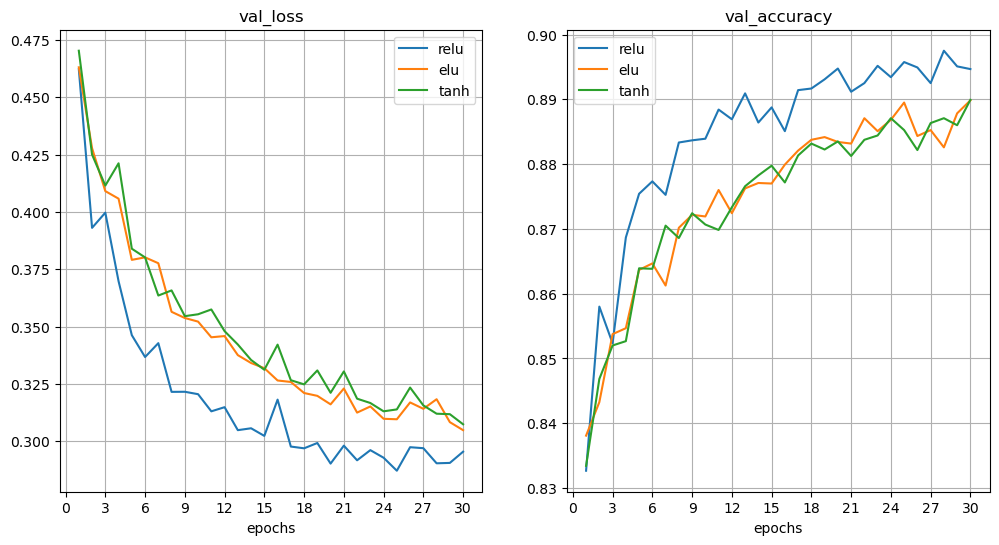

In [30]:
multi_val_loss_accuracy_plotting(val_loss, val_accurasy, title="")

### 9. Контрольна точка з elu на 50 епохах.

Train loss: 0.2117871642112732, train accuracy: 0.92208331823349
Test loss:  0.3233869671821594, test accuracy:  0.8881999850273132

Train
Min loss : 0.24206826090812683, epoch num: 49
Max accuracy : 0.9094791412353516, epoch num: 49

Validation
Min loss : 0.2951716482639313, epoch num: 50
Max accuracy : 0.8956666588783264, epoch num: 50


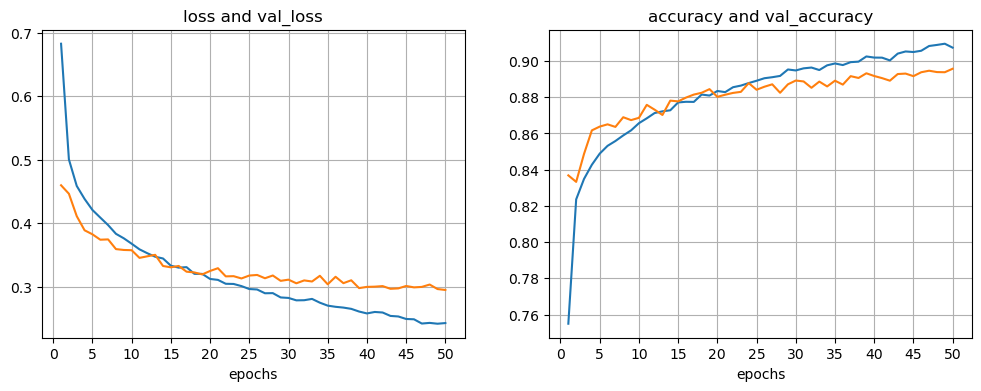

In [31]:
layers = [NLayer(768, 0.5, "elu"), NLayer(256, 0.3, "elu")]
optimizer = Adam(learning_rate=0.0006)

model = create_model(HyperParameters(layers=layers, optimizer=optimizer))
history = model.fit(x_train, y_train_cat, batch_size=BATCH_SIZE, epochs=50, validation_split=0.20, verbose=0)
evaluate_model(model, history.history)

loss_accuracy_plotting(history.history)

Результат +- як з relu але епох більше.

### 10. Різні оптимізатори.

In [32]:
optimizers = [Adam(learning_rate=0.0006), AdamW(learning_rate=0.0006), RMSprop(learning_rate=0.0006)]
opt_names = ["Adam", "AdamW", "RMSprop"]
layers = [NLayer(768, 0.5), NLayer(256, 0.3)]

val_accurasy = {}
val_loss = {}

for i, opt in enumerate(optimizers):
    model = create_model(HyperParameters(layers=layers, optimizer=opt))
    history = model.fit(x_train, y_train_cat, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_split=0.20, verbose=0)
    val_accurasy[opt_names[i]] = history.history["val_categorical_accuracy"]  
    val_loss[opt_names[i]] = history.history["val_loss"]

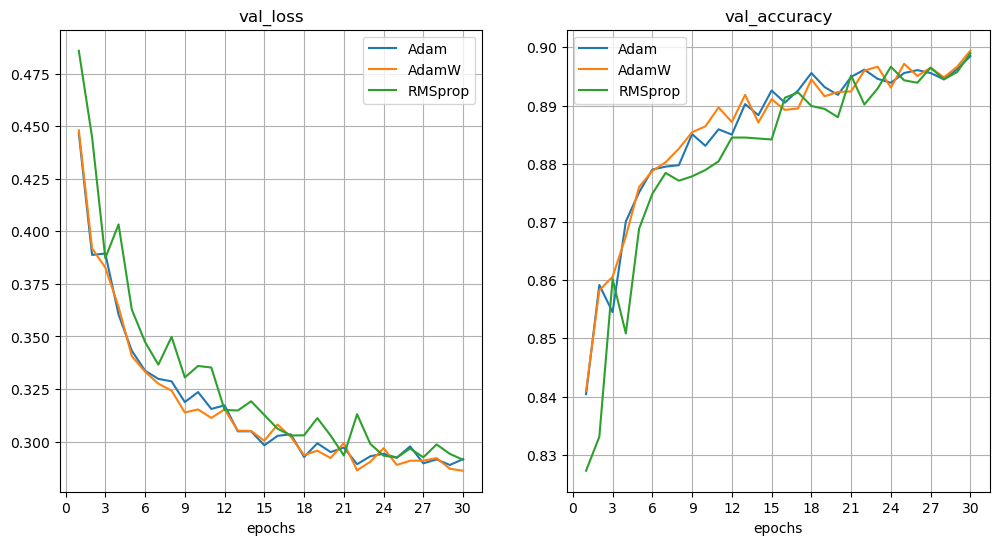

In [33]:
multi_val_loss_accuracy_plotting(val_loss, val_accurasy, title="")

Як на мене - адами більш адекватні.

### 11. Оцінимо роботу нашої моделі.

In [36]:
layers = [NLayer(768, 0.5), NLayer(256, 0.3)]
optimizer = Adam(learning_rate=0.0006)

model = create_model(HyperParameters(layers=layers, optimizer=optimizer))
history = model.fit(x_train, y_train_cat, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_split=0.20, verbose=0)
evaluate_model(model, history.history)

Train loss: 0.20340955257415771, train accuracy: 0.9257833361625671
Test loss:  0.3128950297832489, test accuracy:  0.8944000005722046

Train
Min loss : 0.23382620513439178, epoch num: 30
Max accuracy : 0.9126458168029785, epoch num: 30

Validation
Min loss : 0.28525903820991516, epoch num: 27
Max accuracy : 0.8983333110809326, epoch num: 30


Перевіримо точність по test_data

In [38]:
pred_test = model.predict(x_test)
acc_test = categorical_accuracy(y_test_cat, pred_test).numpy().mean()
print(f"Точність по всьому тестовому датасеті: {acc_test}")

313/313 [==============================] - 1s 2ms/step
Точність по всьому тестовому датасеті: 0.8944000005722046


Побудуємо матрицю помилок.

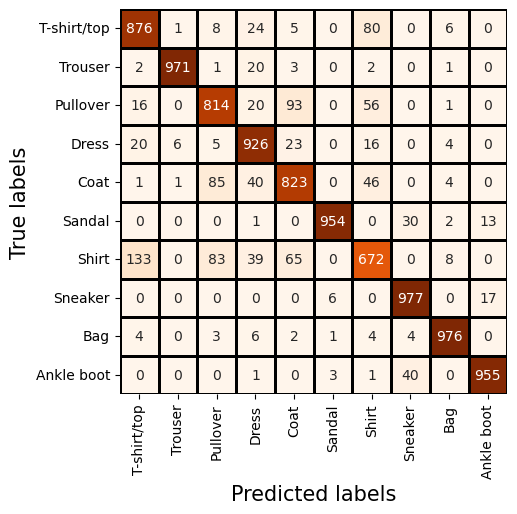

In [39]:
labels = ["T-shirt/top", 
          "Trouser",
          "Pullover",
          "Dress",
          "Coat",
          "Sandal",
          "Shirt",
          "Sneaker",
          "Bag",
          "Ankle boot"]

y_pred = tf.argmax(pred_test, axis=1)

cm = confusion_matrix(y_test, y_pred)
df_confusion_matrix = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(5, 5))
sns.heatmap(df_confusion_matrix, fmt="d", annot=True, cbar=False, cmap="Oranges", linewidths=1, linecolor="black")
plt.xlabel("Predicted labels", fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel("True labels", fontsize=15)
plt.yticks(fontsize=10, rotation=0);

А також підрахуємо точність по кожному класу з нашої тестової вибірки. 

In [40]:
true_idx = np.where(y_test == y_pred)[0]
all_data = pd.DataFrame(y_test.reshape(-1,1), columns=["Label"]).groupby("Label")["Label"].count()
true_data = pd.DataFrame(y_test[[true_idx ]].reshape(-1,1), columns=["Label"]).groupby("Label")["Label"].count() 
accuracy_data = pd.DataFrame({"all_cnt": all_data, "true_cnt": true_data})
accuracy_data["false_cnt"] = accuracy_data["all_cnt"] - accuracy_data["true_cnt"]
accuracy_data["accuracy"] = accuracy_data["true_cnt"] / accuracy_data["all_cnt"]
accuracy_data.index = labels
display(accuracy_data.sort_values("accuracy"))

,all_cnt,true_cnt,false_cnt,accuracy
Shirt,1000,672,328,0.672
Pullover,1000,814,186,0.814
Coat,1000,823,177,0.823
T-shirt/top,1000,876,124,0.876
Dress,1000,926,74,0.926
Sandal,1000,954,46,0.954
Ankle boot,1000,955,45,0.955
Trouser,1000,971,29,0.971
Bag,1000,976,24,0.976
Sneaker,1000,977,23,0.977


Як бачимо в нашій нейромережі з Shirt прям біда якась

### Висновки.
__Реалізований "найнаївніший" підхід до пошуку оптимальних гіперпараметрів нейромережі не виправдав очікувань. Це може свідчити про невміння виконавця вибирати самі параметри, їх діапазони а також послідовність тюнинга. Як варіант потрібно було повчитись в авторів Keras Tuner або купити Thunderobot Zero 2023 і реалізувати тупий перебір можливих комбінацій.  
Але також це може свідчити і про те, що FNN нейромережа не може краще справитись з розпізнаванням наших данних і пора шукати інші варіанти.__